# DeCET application to REMC adult tissues

In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os
import pandas as pd

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '7_21_20' # Change this to today's date for output names.

input_dir = '../DeCET_REMC/' # directory where the HOSVD files can be found
file_prefix = 'DeCET_REMC_adult_tissues_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 34
n_as = 5
fp.close()

sample_proj = np.zeros((n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1]] = projections[k]
assay_name = ['H3K27ac', 'H3K27me3', 
              'H3K9me3', 'H3K4me3', 'H3K4me1']

170 170


In [3]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Select the number of location vectors to use for clustering.
use = [i for i in range(13)]
tissue_sample = np.copy(sample_proj[:,:,use])
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)
    
print(tissue_sample.shape)
D = np.zeros((n_pt, n_pt))
for i in range(n_pt):
    for j in range(n_pt):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

(34, 5, 13)
(34, 5, 13)


In [4]:
# Colors and cell/tissue type labels for the REMC data
distinct_colors = [(180/255, 180/255, 180/255, 1),
                   (255/255, 225/255, 25/255, 1), (0/255, 130/255, 200/255, 1),
                   (245/255, 130/255, 48/255, 1), (145/255, 30/255, 180/255, 1),
                   (70/255, 240/255, 240/255, 1), (240/255, 50/255, 230/255, 1),
                   (210/255, 245/255, 60/255, 1), (250/255, 190/255, 190/255, 1),
                   (0/255, 128/255, 128/255, 1), (230/255, 190/255, 255/255, 1)]

anatomy_colors = [distinct_colors[0], distinct_colors[0], distinct_colors[0],
                  distinct_colors[0], distinct_colors[0], distinct_colors[0],
                  distinct_colors[1], distinct_colors[1], distinct_colors[1],
                  distinct_colors[2], distinct_colors[2], distinct_colors[2],
                  distinct_colors[2], distinct_colors[2],
                  distinct_colors[1], distinct_colors[1],
                  distinct_colors[3], distinct_colors[3], distinct_colors[3],
                  distinct_colors[3], distinct_colors[3],
                  distinct_colors[4], distinct_colors[4],
                  distinct_colors[5], distinct_colors[6],
                  distinct_colors[6], distinct_colors[6], distinct_colors[6],
                  distinct_colors[7], distinct_colors[8], distinct_colors[8],
                  distinct_colors[7], distinct_colors[7], distinct_colors[7]] 
    
anatomy_classes = ["Digestive", "Epithelial", "Brain", "Blood & T cell",
                   "HSC & B cell", "Adipose", "Smooth muscle", "Heart",
                   "Muscle"]

In [5]:
# Reorder the assays to group marks associated with active and repressive
# gene transcription. This makes it easier to see trends in the projections.
reorder_assays = [0,3,4,1,2]

# Colors for the assay and location vectors.
assay_colors = [(51/255,70/255,0,1.0), (204/255,20/255,204/255,1.0), 
                (104/255,20/255,104/255,1.0), (204/255,102/255,0,1.0), (162/255,148/255,80/255,1.0)]
index_order = []
col_loc_color = []
single_col_color = []
col_assay = []
for l in range(len(use)):
    if(l % 2 == 0):
        single_col_color.append('k')
    else:
        single_col_color.append((0.5,0.5,0.5,1))
    for k in range(n_as):
        index_order.append(len(use)*k + l)
        col_assay.append(assay_colors[reorder_assays[k]])
    if(l % 2 == 0):
        for k in range(n_as):
            col_loc_color.append('k')
    else:
        for k in range(n_as):
            col_loc_color.append((0.5,0.5,0.5,1))

In [6]:
# Full and reduced labels for the REMC data files used in this study.
sample_labels = ['E109 Small intestine', 'E079 Esophagus', 'E075 Colonic mucosa',
                 'E106 Sigmoid colon', 'E094 Gastric', 'E101 Rectal mucosa',
                 'E058 Foreskin keratinocyte primary cells', 'E059 Foreskin melanocyte primary cells',
                 'E061 Foreskin melanocyte primary cells',
                 'E071 Brain hippocampus middle', 'E072 Brain inferior temporal lobe',
                 'E073 Brain dorsolateral prefrontal cortex',
                 'E067 Brain angular gyrus', 'E069 Brain cingulate gyrus',
                 'E055 Foreskin fibroblast primary cells', 'E056 Foreskin fibroblast primary cells',
                 'E039 Primary T helper naive cells from peripheral blood',
                 'E038 Primary T helper naive cells from peripheral blood',
                 'E062 Primary mononuclear cells from peripheral blood',
                 'E047 Primary T CD8+ naive cells from peripheral blood',
                 'E048 Primary T CD8+ memory cells from peripheral blood',
                 'E032 Primary B cells from peripheral blood',
                 'E046 Primary NK cells peripheral blood',
                 'E063 Adipose nuclei', 'E076 Colon smooth muscle',
                 'E078 Duodenum smooth muscle', 'E103 Rectal smooth muscle',
                 'E111 Stomach smooth muscle', 'E065 Aorta', 'E100 Psoas muscle',
                 'E108 Skeletal muscle female', 'E095 Left ventricle',
                 'E104 Right atrium', 'E105 Right ventricle']


sample_labels_short = ['E109', 'E079', 'E075', 'E106', 'E094', 'E101',
                       'E058', 'E059', 'E061', 'E071', 'E072', 'E073',
                       'E067', 'E069', 'E055', 'E056', 'E039', 'E038',
                       'E062', 'E047', 'E048', 'E032', 'E046', 'E063',
                       'E076', 'E078', 'E103', 'E111', 'E065', 'E100',
                       'E108', 'E095', 'E104', 'E105']

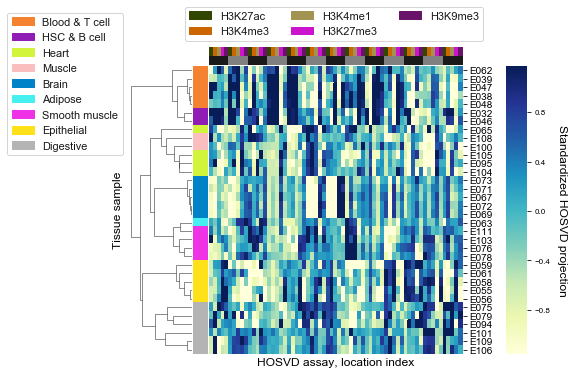

In [7]:
# Figure 6A (unsupervised hierarchical clustering of tissue samples)
legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj, axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=anatomy_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels=[], yticklabels=sample_labels_short, figsize=(6,7),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.82,0.67), handles=legend_an,
                       frameon=True, fontsize=11)

g.cax.legend(loc='lower left', bbox_to_anchor=(-15.1,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=3)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)
# g.savefig(output_dir + 'figures/figure6_panels/' + file_prefix + '_panelA_clustering_' +
#           date + '.pdf', format='pdf', transparent=True)

In [8]:
np.sort(use) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

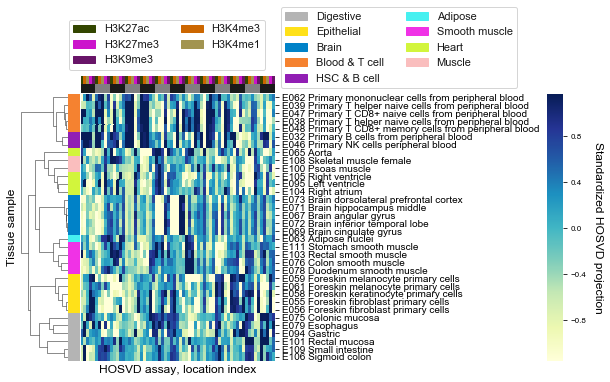

In [9]:
# Same figure as above but with the full sample label
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip(distinct_colors, anatomy_classes)]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip(assay_colors, assay_name)]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0), np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=anatomy_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels = [], yticklabels=sample_labels, figsize=(4.6,6.5),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.72,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(1.0,1.00), handles=legend_an,
                       frameon=True, fontsize=11, ncol=2)

g.cax.legend(loc='lower left', bbox_to_anchor=(-29.2,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=2)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

In [10]:
# Load in the decomposition of the genomic location space.
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_2.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1440549, 170)


In [11]:
# The genomic bins used for the hg19 genome. chrY is 
# removed from the data before the HOSVD. Since chrY is
# at the end of the chromosome list used, this is
# not a problem.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [12]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the location vector of interest (zero indexed).
loc_vec = 11

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,loc_vec] > cut):
        significant_pos.append(i)
    elif(U_l[i,loc_vec] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

# Save the regions exhibiting epigenetic alterations 
# between leiomyoma and myometrium. 1-based indexing
# is used for the file names.

output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(loc_vec+1) + '_final.txt','w+')

for l in range(0,len(significant_pos)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0], genomic_bin[significant_pos[l]][1], genomic_bin[significant_pos[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(loc_vec+1) + '_final.txt','w+')

for l in range(0,len(significant_neg)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0], genomic_bin[significant_neg[l]][1], genomic_bin[significant_neg[l]][2]))
output_neg.close()

1374 positive
1965 negative


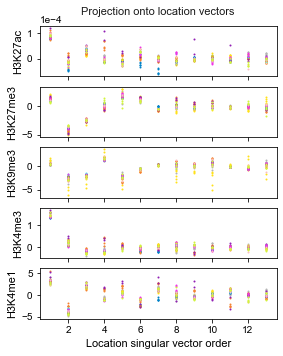

In [13]:
# Stacked projections
fig = plt.figure(figsize=(4.25,6.5))

n_proj = 13
assay_name = ['H3K27ac', 'H3K27me3',
              'H3K9me3', 'H3K4me3', 'H3K4me1']

ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(611+k)) 
    for i in range(n_pt):
        ax[k].plot(sample_proj[i, assay][0:n_proj],'.', markersize=2, c=anatomy_colors[i])

    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)    
    
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])
    plt.setp(ax[k].get_xticklabels(), visible=True)
    plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

In [14]:
# Read the REMC metadata. This can be obtained from https://egg2.wustl.edu/roadmap/web_portal/meta.html
REMC_meta = pd.read_csv('../Roadmap.metadata.qc.jul2013 - Consolidated_EpigenomeIDs_summary_Table.csv')

In [15]:
# Get the generating lab label from the metadata for each
# of the samples used in this study.
sample_lab_labels = []
for i in sample_labels_short:
    print(i,
          REMC_meta.loc[REMC_meta.loc[:,'Epigenome ID (EID)'] == i].loc[:,'LAB\n(Based on 5 core histone marks only)'].values[0])
    sample_lab_labels.append(i + ', ' + REMC_meta.loc[REMC_meta.loc[:,'Epigenome ID (EID)'] == i].loc[:,'LAB\n(Based on 5 core histone marks only)'].values[0])

E109 UCSD
E079 UCSD
E075 BI
E106 UCSD
E094 UCSD
E101 BI
E058 UCSF-UBC
E059 UCSF-UBC
E061 UCSF-UBC
E071 BI
E072 BI
E073 BI
E067 BI
E069 BI
E055 UCSF-UBC
E056 UCSF-UBC
E039 BI
E038 BI;UCSF-UBC
E062 UCSF-UBC
E047 BI;UCSF-UBC
E048 BI
E032 UW
E046 UW
E063 BI
E076 BI
E078 BI
E103 BI
E111 BI
E065 UCSD
E100 UCSD
E108 BI
E095 UCSD
E104 UCSD
E105 UCSD


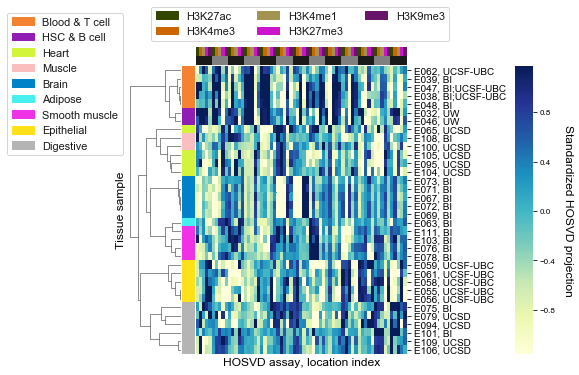

In [16]:
# Figure 6A (unsupervised hierarchical clustering of tissue samples with generating lab labels)
legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj, axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=anatomy_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels=[], yticklabels=sample_lab_labels, figsize=(5.0,7),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.2,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.92,0.67), handles=legend_an,
                       frameon=True, fontsize=11)

g.cax.legend(loc='lower left', bbox_to_anchor=(-20.5,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=3)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)
g.savefig(output_dir + 'figures/figure6_panels/' + file_prefix + '_panelA_clustering_lab_' +
          date + '.pdf', format='pdf', transparent=True)

## Jaccard index clustering for this dataset

broadPeak files were obtained for each sample for each of the 5 histone modifications from https://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/broadPeak/

For each histone modifcation, the pairwise Jaccard index for samples i and j was obtained using

bedtools jaccard -a i -b j

The pairwise similarity matrix for each histone modification was saved as a tab separated text file with the Jaccard index for sample i and j saved as the ith line and jth column entry in the file. The samples are ordered according to the sample labels provided above.


In [17]:
# Read the Jaccard similarity matrix for a single histone.
# The samples are ordered according to the labels above.
similarity_matrix = pd.read_csv(input_dir + 'DeCET_REMC_adult_tissues_H3K4me1_broadPeak_Jaccard.txt',
                                delimiter='\t', header=None, index_col=None)

In [18]:
similarity_matrix.iloc[:,:-1]

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.000000,0.251834,0.320707,0.323018,0.284009,0.339974,0.282687,0.247031,0.285931,0.323218,...,0.315921,0.364212,0.268501,0.314353,0.266490,0.301133,0.322405,0.308898,0.307148,0.310462
1,0.251831,1.000000,0.306086,0.240984,0.363940,0.265577,0.297176,0.313010,0.217405,0.277004,...,0.231998,0.257993,0.194812,0.309017,0.217198,0.256209,0.313644,0.303907,0.319302,0.365201
2,0.320705,0.306086,1.000000,0.309558,0.309970,0.357460,0.293911,0.297478,0.266876,0.324468,...,0.304580,0.338436,0.257919,0.340813,0.221484,0.262754,0.349747,0.290681,0.293555,0.334565
3,0.323018,0.240984,0.309559,1.000000,0.268584,0.319750,0.265527,0.239234,0.244554,0.280716,...,0.301382,0.313019,0.254526,0.281352,0.223402,0.276953,0.305679,0.290418,0.280541,0.266631
4,0.284000,0.363939,0.309970,0.268583,1.000000,0.281944,0.274408,0.302853,0.230695,0.288396,...,0.244795,0.278275,0.206510,0.308637,0.239229,0.277069,0.315360,0.316206,0.329387,0.367698
5,0.340375,0.265958,0.357481,0.319915,0.282254,1.000000,0.285979,0.265743,0.275833,0.323952,...,0.311520,0.352582,0.269198,0.320935,0.225998,0.260040,0.332996,0.276854,0.277956,0.304534
6,0.282736,0.297216,0.293913,0.265551,0.274453,0.285747,1.000000,0.296352,0.298321,0.299098,...,0.285471,0.305926,0.246796,0.302409,0.214443,0.253639,0.325926,0.271286,0.265410,0.297750
7,0.247031,0.313013,0.297480,0.239235,0.302865,0.265677,0.296346,1.000000,0.368310,0.317813,...,0.258396,0.278293,0.221355,0.308948,0.193873,0.240846,0.323974,0.275131,0.276078,0.335290
8,0.285931,0.217407,0.266878,0.244554,0.230704,0.275708,0.298316,0.368310,1.000000,0.344623,...,0.299494,0.320687,0.265058,0.288403,0.214164,0.250424,0.305041,0.260541,0.250853,0.271058
9,0.323218,0.277006,0.324470,0.280716,0.288406,0.323755,0.299088,0.317813,0.344622,1.000000,...,0.375482,0.401281,0.313657,0.372731,0.249226,0.307618,0.402637,0.333921,0.326863,0.352486


In [19]:
# The Jaccard similarity matrix must be symmetric for clustering. 
# There are small differences in the Jaccard index calculated by 
# switching the file order. This is corrected here by setting the
# entries above the diagonal to the corresponding entries of the
# transposed similarity matrix.
similarity_matrix_corrected = np.copy(similarity_matrix.values[:,:-1])
for i in range(similarity_matrix_corrected.shape[0]):
    for j in range(similarity_matrix_corrected.shape[1]):
        similarity_matrix_corrected[i,j] = similarity_matrix_corrected[j,i]
del similarity_matrix

In [20]:
pd.DataFrame(similarity_matrix_corrected)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.000000,0.251831,0.320705,0.323018,0.284000,0.340375,0.282736,0.247031,0.285931,0.323218,...,0.316368,0.364211,0.268501,0.314351,0.266488,0.301131,0.322405,0.308898,0.307148,0.310461
1,0.251831,1.000000,0.306086,0.240984,0.363939,0.265958,0.297216,0.313013,0.217407,0.277006,...,0.232398,0.257993,0.194814,0.309018,0.217198,0.256209,0.313647,0.303908,0.319302,0.365201
2,0.320705,0.306086,1.000000,0.309559,0.309970,0.357481,0.293913,0.297480,0.266878,0.324470,...,0.304604,0.338436,0.257921,0.340814,0.221484,0.262754,0.349749,0.290683,0.293556,0.334565
3,0.323018,0.240984,0.309559,1.000000,0.268583,0.319915,0.265551,0.239235,0.244554,0.280716,...,0.301581,0.313018,0.254526,0.281352,0.223402,0.276953,0.305679,0.290418,0.280541,0.266631
4,0.284000,0.363939,0.309970,0.268583,1.000000,0.282254,0.274453,0.302865,0.230704,0.288406,...,0.245116,0.278276,0.206514,0.308638,0.239230,0.277069,0.315371,0.316208,0.329388,0.367698
5,0.340375,0.265958,0.357481,0.319915,0.282254,1.000000,0.285747,0.265677,0.275708,0.323755,...,0.311523,0.352388,0.269172,0.320911,0.225776,0.259835,0.332990,0.276653,0.277718,0.304306
6,0.282736,0.297216,0.293913,0.265551,0.274453,0.285747,1.000000,0.296346,0.298316,0.299088,...,0.285764,0.305906,0.246793,0.302404,0.214419,0.253624,0.325925,0.271265,0.265379,0.297724
7,0.247031,0.313013,0.297480,0.239235,0.302865,0.265677,0.296346,1.000000,0.368310,0.317813,...,0.258477,0.278291,0.221355,0.308943,0.193871,0.240844,0.323973,0.275131,0.276078,0.335288
8,0.285931,0.217407,0.266878,0.244554,0.230704,0.275708,0.298316,0.368310,1.000000,0.344622,...,0.299666,0.320685,0.265058,0.288399,0.214162,0.250422,0.305041,0.260540,0.250853,0.271056
9,0.323218,0.277006,0.324470,0.280716,0.288406,0.323755,0.299088,0.317813,0.344622,1.000000,...,0.375772,0.401280,0.313657,0.372728,0.249225,0.307616,0.402637,0.333921,0.326863,0.352485


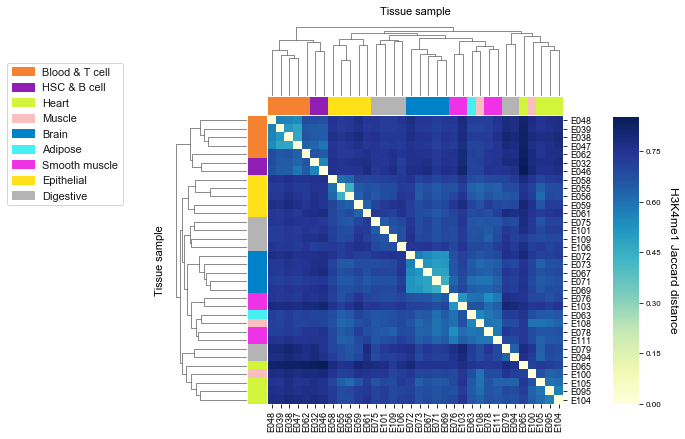

In [21]:
# Cluster the tissue samples based on the Jaccard similarity matrix for 
# a given histone modification.
legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_corrected), method='complete')

g = seaborn.clustermap(1 - similarity_matrix_corrected, row_linkage=linkage, col_linkage=linkage, cmap="YlGnBu", 
                       row_cluster=True, col_cluster=True, robust=False, row_colors=anatomy_colors, col_colors=anatomy_colors,
                       xticklabels=sample_labels_short, yticklabels=sample_labels_short, figsize=(7,7))

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('H3K4me1 Jaccard distance', rotation=270, fontsize=12, labelpad=17)

l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.9,0.67), handles=legend_an,
                       frameon=True, fontsize=11)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.xaxis.set_label_coords(0.5,1.38)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

In [22]:
def quantile_normalize(*args):
    """Quantile normalize a set of equal length lists.
    
    The lists are assumed to be of the same length.
    Quantile normalization is performed by sorting
    each of the lists and taking the mean of the
    sorted lists. The entry with the greatest value 
    for each list is then set to the mean of the 
    greatest values from all the lists. This is repeated
    for the 2nd greatest entry, and so on.
    """
    K = len(args)
    X_argsort = np.zeros((K, len(args[0])), dtype=np.int)
    q_norm = np.zeros(len(args[0]))
    X_qnorm = np.zeros((K, len(args[0])))
    
    for i in range(K):
        q_norm += np.sort(args[i])
    q_norm /= K
    
    for i in range(K):
        X_argsort[i] = np.argsort(args[i])
        for j in range(len(args[i])):
            X_qnorm[i, X_argsort[i,j]] = q_norm[j]
    
    return [X_qnorm[i,:] for i in range(K)]

In [23]:
# Cluster using a combined Jaccard similarity.
# Read the Jaccard index similarity matrix for each histone modification.
jaccard_similarity_H3K27ac = pd.read_csv(input_dir + 'DeCET_REMC_adult_tissues_H3K27ac_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K27ac = pd.DataFrame(jaccard_similarity_H3K27ac.values[:,:-1])

jaccard_similarity_H3K4me3 = pd.read_csv(input_dir + 'DeCET_REMC_adult_tissues_H3K4me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K4me3 = pd.DataFrame(jaccard_similarity_H3K4me3.values[:,:-1])

jaccard_similarity_H3K4me1 = pd.read_csv(input_dir + 'DeCET_REMC_adult_tissues_H3K4me1_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K4me1 = pd.DataFrame(jaccard_similarity_H3K4me1.values[:,:-1])

jaccard_similarity_H3K27me3 = pd.read_csv(input_dir + 'DeCET_REMC_adult_tissues_H3K27me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K27me3 = pd.DataFrame(jaccard_similarity_H3K27me3.values[:,:-1])

jaccard_similarity_H3K9me3 = pd.read_csv(input_dir + 'DeCET_REMC_adult_tissues_H3K9me3_broadPeak_Jaccard.txt', sep = '\t',
                                header = None, index_col = None)
jaccard_similarity_H3K9me3 = pd.DataFrame(jaccard_similarity_H3K9me3.values[:,:-1])

In [24]:
# Obtain a combined similarity by summing the Jaccard
# similarities for each histone modification.
similarity_matrix_combined = jaccard_similarity_H3K27ac.values + \
                             jaccard_similarity_H3K4me3.values + \
                             jaccard_similarity_H3K4me1.values + \
                             jaccard_similarity_H3K27me3.values + \
                             jaccard_similarity_H3K9me3.values

In [25]:
pd.DataFrame(similarity_matrix_combined)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,5.000000,1.261230,1.363704,1.791000,1.209132,1.525537,1.189155,1.131026,1.146561,1.428213,...,1.271631,1.509992,1.329036,1.286251,1.085020,1.348583,1.445699,1.390956,1.075125,1.259284
1,1.261227,5.000000,1.266350,1.214867,1.379763,1.227891,1.203361,1.288004,1.041631,1.208501,...,1.059343,1.191644,1.123695,1.168694,1.064914,1.064765,1.291966,1.283108,1.106842,1.222553
2,1.363700,1.266348,5.000000,1.338911,1.191234,1.617410,1.274032,1.284584,1.164367,1.386774,...,1.302377,1.434275,1.353759,1.398383,0.942820,1.121151,1.466935,1.170426,1.020592,1.259828
3,1.790999,1.214867,1.338912,5.000000,1.211599,1.505511,1.153632,1.115925,1.089065,1.371018,...,1.250153,1.420256,1.269038,1.205086,1.064582,1.320283,1.374023,1.359650,1.005580,1.230826
4,1.209111,1.379751,1.191234,1.211597,5.000000,1.138961,1.064664,1.224413,1.010908,1.169221,...,1.055051,1.101762,1.032762,1.072775,0.958904,1.055210,1.178441,1.197553,0.948663,1.208757
5,1.525938,1.228272,1.617432,1.505678,1.139282,5.000000,1.285382,1.154091,1.186908,1.476586,...,1.362027,1.611561,1.461561,1.398219,1.004691,1.226827,1.571421,1.262033,1.096190,1.260348
6,1.189235,1.203472,1.274077,1.153715,1.064788,1.285185,5.000000,1.276609,1.440389,1.316697,...,1.139788,1.312608,1.156391,1.222944,0.939649,1.184809,1.340958,1.182288,1.024778,1.264009
7,1.131021,1.288006,1.284596,1.115927,1.224429,1.154029,1.276589,5.000000,1.435373,1.296708,...,1.086533,1.129033,1.102707,1.255919,0.903701,0.967198,1.232319,1.050143,0.912205,1.271498
8,1.146568,1.041646,1.164389,1.089078,1.010944,1.186801,1.440367,1.435380,5.000000,1.370820,...,1.147831,1.250733,1.100808,1.131928,0.904776,1.125165,1.234647,1.137223,0.974150,1.210367
9,1.428213,1.208503,1.386777,1.371017,1.169241,1.476389,1.316635,1.296709,1.370794,5.000000,...,1.490894,1.711552,1.393624,1.494282,1.079000,1.376840,1.642432,1.389686,1.187618,1.478838


In [26]:
# Correct entries that are not symmetric using the same approach
# as above and take the average similarity across histones.
for i in range(similarity_matrix_combined.shape[0]):
    for j in range(similarity_matrix_combined.shape[1]):
        similarity_matrix_combined[i,j] = similarity_matrix_combined[j,i]
similarity_matrix_combined /= 5.0

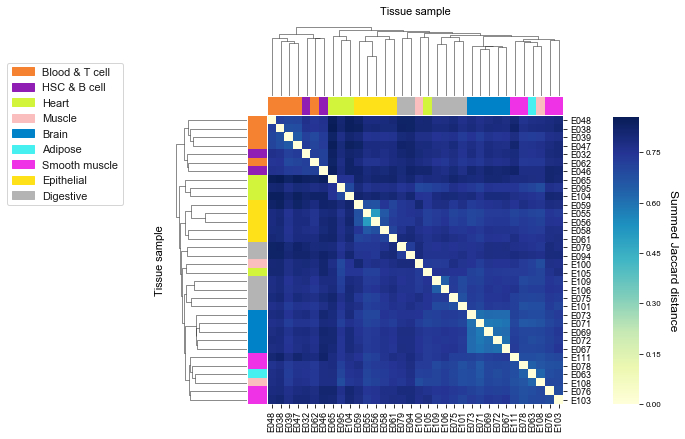

In [27]:
# Cluster based on the Jaccard similarity summed across histones.
from matplotlib.legend import Legend
legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_combined), method='complete')

g = seaborn.clustermap(1 - similarity_matrix_combined, row_linkage=linkage, col_linkage=linkage, cmap="YlGnBu", 
                       row_cluster=True, col_cluster=True, robust=False, row_colors=anatomy_colors, col_colors=anatomy_colors,
                       xticklabels=sample_labels_short, yticklabels=sample_labels_short, figsize=(7,7))

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Summed Jaccard distance', rotation=270, fontsize=12, labelpad=17)

l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.9,0.67), handles=legend_an,
                       frameon=True, fontsize=11)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.xaxis.set_label_coords(0.5,1.38)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

In [28]:
# Apply the quantile normalization to the Jaccard
# similarities for each histone.
jaccard_similarity_qnorm = quantile_normalize(jaccard_similarity_H3K27ac.values.flatten(),
                                              jaccard_similarity_H3K4me3.values.flatten(),
                                              jaccard_similarity_H3K4me1.values.flatten(),
                                              jaccard_similarity_H3K27me3.values.flatten(),
                                              jaccard_similarity_H3K9me3.values.flatten())

for k in range(n_as):
    jaccard_similarity_qnorm[k] = np.reshape(jaccard_similarity_qnorm[k], jaccard_similarity_H3K27ac.shape)

In [29]:
# Obtain a combined similarity by summing the
# quantile normalized similarities across histones.
# jaccard_similarity_combined_qnorm = sum(jaccard_similarity_qnorm)
similarity_matrix_combined_qnorm = sum(jaccard_similarity_qnorm)

In [30]:
# Correct entries that are not symmetric using the same approach
# as above and take the average similarity across histones.
# similarity_matrix_combined_qnorm = np.copy(jaccard_similarity_combined_qnorm)
for i in range(similarity_matrix_combined_qnorm.shape[0]):
    for j in range(similarity_matrix_combined_qnorm.shape[1]):
        similarity_matrix_combined_qnorm[i,j] = similarity_matrix_combined_qnorm[j,i]
similarity_matrix_combined_qnorm /= 5.0

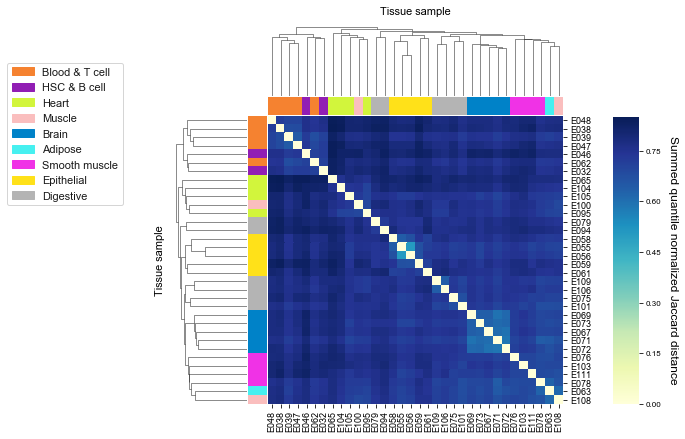

In [31]:
# Cluster based on the quantile normalized Jaccard 
# similarity summed across histones.
legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_combined_qnorm), method='complete')

g = seaborn.clustermap(1 - similarity_matrix_combined_qnorm, row_linkage=linkage, col_linkage=linkage, cmap="YlGnBu", 
                       row_cluster=True, col_cluster=True, robust=False, row_colors=anatomy_colors, col_colors=anatomy_colors,
                       xticklabels=sample_labels_short, yticklabels=sample_labels_short, figsize=(7,7))

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.cax.set_position([1.0,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Summed quantile normalized Jaccard distance', rotation=270, fontsize=12, labelpad=17)

l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.9,0.67), handles=legend_an,
                       frameon=True, fontsize=11)

g.ax_heatmap.set_xlabel('Tissue sample', fontsize=11)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=11)
g.ax_heatmap.xaxis.set_label_coords(0.5,1.38)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)

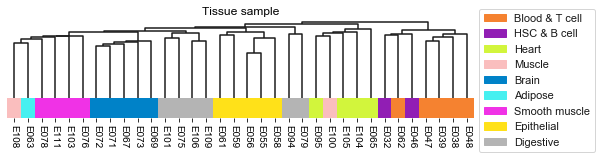

In [32]:
# Figure 8A (Jaccard index clustering of REMC adult tissue samples)
# Plot the dendrogram for the combined quantile normalized clustering.
fig = plt.figure(figsize=(5.4,5.5))
ax_den = fig.add_axes([0.0,0.05,1.2,0.2])

linkage = hc.linkage(sp.distance.squareform(1 - similarity_matrix_combined_qnorm), method='complete')

d = scipy.cluster.hierarchy.dendrogram(linkage, labels=None, leaf_rotation=0, no_labels=True,
                                       orientation="top", color_threshold=0, above_threshold_color='k')

ax_den.set(frame_on=False)
ax_den.xaxis.set_ticks([])
ax_den.yaxis.set_ticks([])
ax_den.set_xlabel('Tissue sample', fontsize=12)
ax_den.xaxis.set_label_position('top') 

ax_col=fig.add_axes([0.0,0.0,1.2,0.05])

for i, leaf in enumerate(scipy.cluster.hierarchy.leaves_list(linkage)):
    ax_col.add_patch(mpatches.Rectangle((i/n_pt,0.0), 1.0/n_pt, 1.0,  ec=None, fc=anatomy_colors[leaf]))

ax_col.yaxis.set_ticks([])
ax_col.xaxis.set_ticks_position('bottom')
ax_col.xaxis.set_ticks([i/n_pt + 0.5/n_pt for i in range(n_pt)])
ax_col.xaxis.set_ticklabels([sample_labels_short[i] for i in scipy.cluster.hierarchy.leaves_list(linkage)], fontsize=10, rotation=270, ha='center')
ax_col.set(frame_on=False)

legend_order = [3, 4, 7, 8, 2, 5, 6, 1, 0]
legend_an = [mpatches.Patch(color=c, label=l) for c,l in zip([distinct_colors[i] for i in legend_order], [anatomy_classes[i] for i in legend_order])]
ax_col.legend(loc='lower left', bbox_to_anchor=(1.0,-2.0), handles=legend_an,
              frameon=True, fontsize=11)

ax_col.set_xlim(ax_col.get_xlim()[::-1])
ax_den.set_xlim(ax_den.get_xlim()[::-1])

plt.savefig(output_dir + 'figures/figure8_panels/' + file_prefix + '_panelA_Jaccard_clustering_' +
            date + '.pdf', format='pdf', transparent=True, bbox_inches='tight')